[View in Colaboratory](https://colab.research.google.com/github/nfmorenog/Sistemas-inteligentes/blob/master/iis_practica2_nfmorenog_jntorresm.ipynb)

#Práctica 2
##Clasificación no lineal, complejidad y sobreajuste
###Introducción a los Sistemas Inteligentes

####Presentado por: Nelson Felipe Moreno Gómez y Johan Nicolas Torres Mendoza

Siguiendo con el uso del conjunto de datos Wine usado en la práctica anterior:

###1. Cargamos el conjunto de datos Wine como un DataFrame de pandas.

In [1]:
# https://pypi.python.org/pypi/pydot-
!apt install graphviz
!pip install graphviz
!pip install pydot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 30 newly installed, 0 to remove and 4 not upgraded.
Need to get 4,154 kB of

In [156]:
!pip install tabulate

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn import datasets
from sklearn.datasets import make_moons
import graphviz 
from sklearn.tree import export_graphviz
import pydot
from sklearn.metrics import confusion_matrix
from tabulate import tabulate


def plot_data(X, y):   #Función para graficar datos (X,y)
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region2(X, pred_fun):      #Función para visualizar la superficie de decisión de nuestro algoritmo.
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 1, vmax=3)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def list_cm(cm, classes):     #función para generar de una forma más visual la matriz de confusión
    if len(cm)==2:
      cm.astype(int)
      row_0 =['','Valor','Verdadero']
      row_1 =['-',classes[0],classes[1]]
      row_2 =[classes[0],cm[0,0],cm[1,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1]]
      table = zip(row_0,row_1, row_2, row_3)
      headers = ['', '', 'Valor', 'Predicho']  
      return print(tabulate(table, headers=headers, floatfmt=".0f"))
    else:
      cm.astype(int)
      row_0 =['','Valor','Verdadero','']
      row_1 =['-',np.int(classes[0]),classes[1],classes[2]]
      row_2 =[classes[0],cm[0,0],cm[1,0],cm[2,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1],cm[2,1]]
      row_4 =[classes[2],cm[0,2],cm[1,2],cm[2,2]]
      table = zip(row_0,row_1, row_2, row_3, row_4)
      headers = ['', '', 'Valor', 'Predicho', '']  
      return print(tabulate(table, headers=headers, floatfmt=".0f")) 

    100% |████████████████████████████████| 51kB 3.5MB/s 
  Running setup.py bdist_wheel for tabulate ... - done
  Stored in directory: /root/.cache/pip/wheels/2a/85/33/2f6da85d5f10614cbe5a625eab3b3aebfdf43e7b857f25f829
Successfully built tabulate


In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Autenticación y creación del cliente PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile({'q': "'1X_IvhuG5nli8bUly-6PPJovQRGCSq0lH' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))
  
train_downloaded = drive.CreateFile({'id': '11pvH069hKkdzFC0HYQQ6v0fwAjzdYEd5'})
train_downloaded.GetContentFile('wine.data.txt')  


title: wine.data.txt, id: 11pvH069hKkdzFC0HYQQ6v0fwAjzdYEd5


In [0]:
import pandas as pd

from pandas.plotting import scatter_matrix
wine_df = pd.read_csv('wine.data.txt')
class_array=wine_df["Class"]
y= class_array.values
wine_df1 = wine_df.drop(columns=["Class"])
#print(class_array)
#print(y)


###2. Generamos una partición estratificada 70-30 sobre el conjunto de datos cargados.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(wine_df, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)

X_train0, X_test0, y_train0, y_test0 = train_test_split(wine_df1, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)


###3. Generamos una gráfica de barras en Pandas que verifique las particiones de entrenamiento y probamos tengan la misma distribución de clases.¶

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabee41c7b8>]],
      dtype=object)

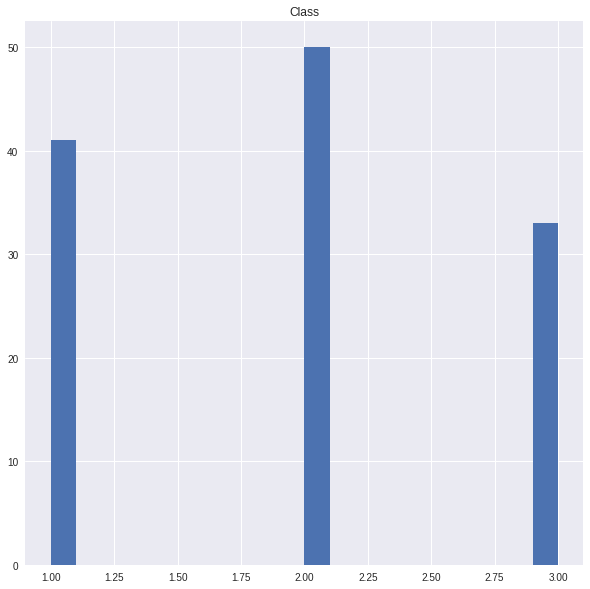

In [6]:
X_train.hist(column = "Class",bins=20,figsize=(10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabeb74aa20>]],
      dtype=object)

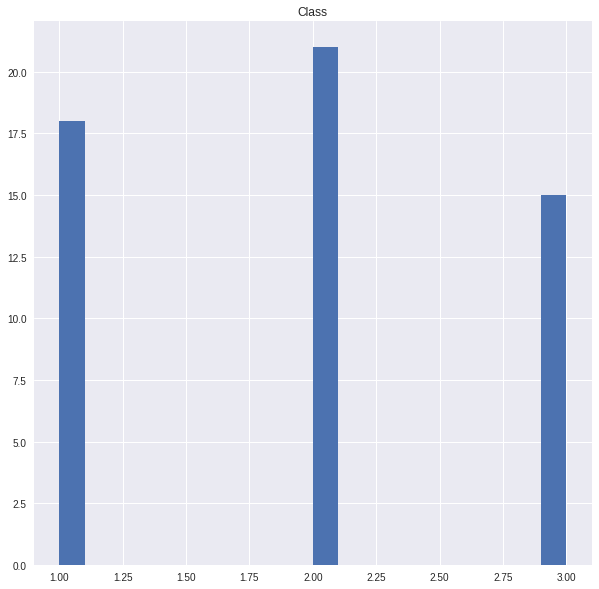

In [33]:
X_test.hist(column = "Class",bins=20,figsize=(10,10))


##Explorando la complejidad usando KNearestNeighbor
###4. Entrenamos un modelo KNearestNeighbor. Usamos los siguientes valores para evaluar la complejidad:


*   $[1, 2, 3, \dots, 20]$
*  Graficamos los errores de entrenamiento y generalización conforme a la complejidad el modelo aumenta.




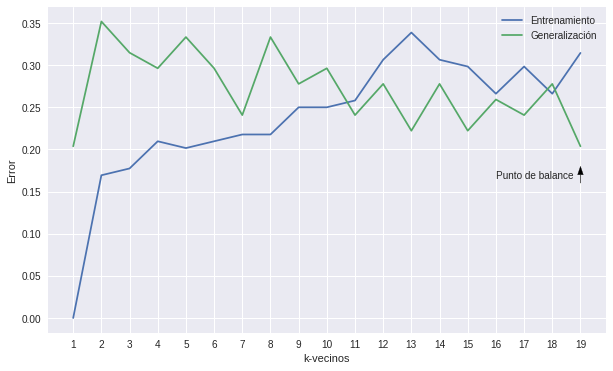

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)


k_values = list(range(1, 20))
train_error = []
generalization_error = []

for nn in k_values:
    knn = KNeighborsClassifier(n_neighbors=nn)
    knn.fit(X_train, y_train)
    train_error.append(1 - knn.score(X_train, y_train))
    generalization_error.append(1 - knn.score(X_test, y_test))
    
pl.figure(figsize = (10, 6))
pl.plot(k_values, train_error, label="Entrenamiento")
pl.plot(k_values, generalization_error, label="Generalización")
pl.xticks(k_values)
pl.xlabel("k-vecinos")
pl.ylabel("Error")
#pl.gca().invert_xaxis()
pl.arrow(19, 0.16, 0, 0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(16, 0.165, 'Punto de balance')
pl.legend();
  

###5. Construimos un conjunto de datos usando las características Proline contra Flavonoids.




*   Usamos la partición 70-30 definida al inicio
*    Usando KNearestNeighbor, determinamos el número óptimo de k-vecinos usando evaluación de la complejidad. Use los mismos valores de $k$:$[1, 2, 3, \dots, 20]$


*   Graficamos la superficie de decisión contra los ejemplos de test.
*   Reportamos accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro sobre el conjunto de prueba.





In [9]:
wine_df.columns

Index(['Class', 'Alcohol', ' Malic_acid', ' Ash', ' Alcalinity', ' Magnesium',
       ' Phenols', ' Flavanoids', ' Nonflavanoid', ' Proanthocyanins', 'Color',
       ' Hue', ' OD280/OD315', ' Proline    '],
      dtype='object')

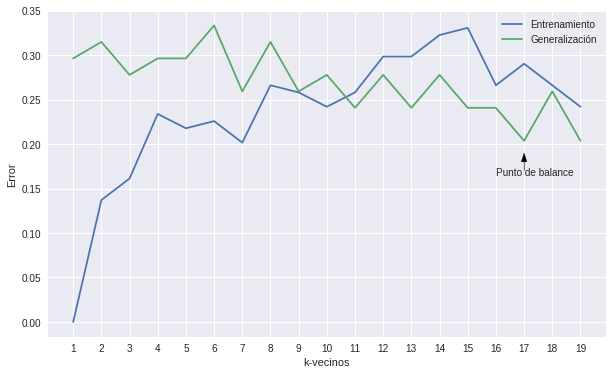

In [159]:
from sklearn.model_selection import train_test_split
X = wine_df.values[:,[7, 13]]
y= class_array.values

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)
k_values = list(range(1, 20))
train_error = []
generalization_error = []

for nn in k_values:
    knn = KNeighborsClassifier(n_neighbors=nn)
    knn.fit(X_train1, y_train1)
    train_error.append(1 - knn.score(X_train1, y_train1))
    generalization_error.append(1 - knn.score(X_test1, y_test1))
    
pl.figure(figsize = (10, 6))
pl.plot(k_values, train_error, label="Entrenamiento")
pl.plot(k_values, generalization_error, label="Generalización")
pl.xticks(k_values)
pl.xlabel("k-vecinos")
pl.ylabel("Error")
#pl.gca().invert_xaxis()
pl.arrow(17, 0.17, 0, 0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(16, 0.165, 'Punto de balance')
pl.legend();









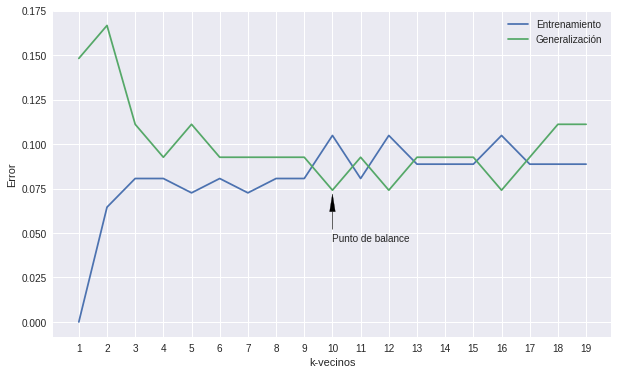

In [152]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


wine_df1= wine_df.drop(columns=["Class"])
X_norm = wine_df1.values

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_norm)
wine_norm_df = pd.DataFrame(x_scaled,columns=wine_df1.columns)


X_norm = wine_norm_df.values[:,[6, 12]]
y_norm= class_array.values
Xn_train1, Xn_test1, yn_train1, yn_test1 = train_test_split(X_norm, y_norm,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)
k_values = list(range(1, 20))
train_error = []
generalization_error = []

for nn in k_values:
    knn = KNeighborsClassifier(n_neighbors=nn)
    knn.fit(Xn_train1, yn_train1)
    train_error.append(1 - knn.score(Xn_train1, yn_train1))
    generalization_error.append(1 - knn.score(Xn_test1, yn_test1))
    
pl.figure(figsize = (10, 6))
pl.plot(k_values, train_error, label="Entrenamiento")
pl.plot(k_values, generalization_error, label="Generalización")
pl.xticks(k_values)
pl.xlabel("k-vecinos")
pl.ylabel("Error")
#pl.gca().invert_xaxis()
pl.arrow(10, 0.052, 0, 0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(10, 0.045, 'Punto de balance')
pl.legend();


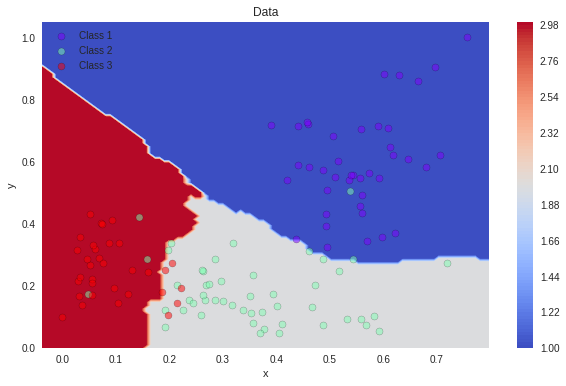

In [153]:

wine_df1= wine_df.drop(columns=["Class"])
X_norm = wine_df1.values

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_norm)
wine_norm_df = pd.DataFrame(x_scaled,columns=wine_df1.columns)


X_norm = wine_norm_df.values[:,[6, 12]]
y_norm= class_array.values
Xn_train1, Xn_test1, yn_train1, yn_test1 = train_test_split(X_norm, y_norm,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)
knn = KNeighborsClassifier(n_neighbors=17)

knn.fit(Xn_train1, yn_train1)
pl.figure(figsize = (10, 6)) 
plot_decision_region2(Xn_train1, gen_pred_fun(knn))
plot_data(Xn_train1, yn_train1)
#standard Normalizer

In [162]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train1, y_train1)


class_names=list(set(y))
y_pred = knn.predict(X)
mat = confusion_matrix(y, y_pred)
list_cm(mat,class_names)

print('Accuracy classifier Proline vs Flavonoids: {}'.format(knn.score(X, y)))

def error(matrix):
  TP = 0
  FP = 0
  FN = 0

  for i in range(len(matrix)): 
    for j in range(len(matrix)): 
      if i==j:
         TP += matrix[i][j]
      if i>j:
         FP += matrix[i][j]

      if i<j:
         FN += matrix[i][j]
  t_error= (FP+FN)/(TP+FN+FP)

  return t_error

print("error classifier Proline vs Flavonoids: ",error(mat))


                 Valor    Predicho
---------  --  -------  ----------  --
           -         1           2   3
Valor      1        53           0   6
Verdadero  2         4          58   9
           3         5          23  20
Accuracy classifier Proline vs Flavonoids: 0.7359550561797753
error classifier Proline vs Flavonoids:  0.2640449438202247


In [163]:
from sklearn.metrics import recall_score, f1_score
print ("Proline vs Flavonoids")

print('Recall macro: {}'.format(recall_score(y, y_pred, average='macro')))
print('Recall micro: {}'.format(recall_score(y, y_pred, average='micro')))
print('Recall pesada: {}'.format(recall_score(y, y_pred, average='weighted')))

Proline vs Flavonoids
Recall macro: 0.7106243866210445
Recall micro: 0.7359550561797753
Recall pesada: 0.7359550561797753



##Explorando la complejidad usando DecisionTree
###6. Entrenamos un modelo de árbol de decisión(Proline contra Flavonoids) usando los siguientes valores de profundidad:
$[1, 2, 3, 4, 5, 7, 8, 9, 10]$
Graficamos los errores de entrenamiento y generalización conforme a la complejidad el modelo aumenta.

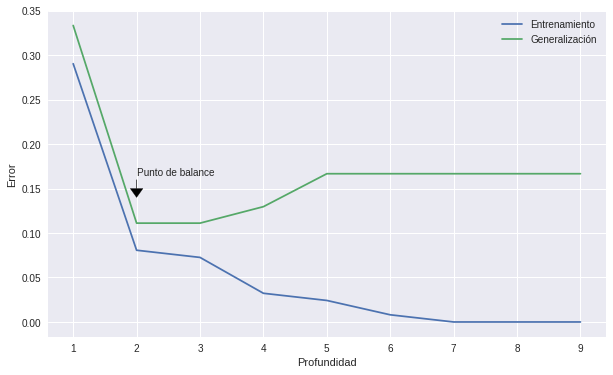

In [141]:
from sklearn.tree import DecisionTreeClassifier
Dtc = DecisionTreeClassifier(max_depth=1)


depth_values = list(range(1, 10))
train_error = []
generalization_error = []

for nn in depth_values:
    Dtc = DecisionTreeClassifier(max_depth=nn)
    Dtc.fit(X_train1, y_train1)
    train_error.append(1 - Dtc.score(X_train1, y_train1))
    generalization_error.append(1 - Dtc.score(X_test1, y_test1))
    
pl.figure(figsize = (10, 6))
pl.plot(depth_values, train_error, label="Entrenamiento")
pl.plot(depth_values, generalization_error, label="Generalización")
pl.xticks(depth_values)
pl.xlabel("Profundidad")
pl.ylabel("Error")
#pl.gca().invert_xaxis()
pl.arrow(2, 0.16, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(2, 0.165, 'Punto de balance')
pl.legend();


###7. Construyamos un conjunto de datos usando las características Alcalinity contra Malic Acid.


*   Usamos la partición 70-30 definida al inicio

*  Usando DecisionTree, determine el número subóptimo de profundidad máxima usando evaluación de la complejidad. Use los mismos valores de $\textit{max_depth}$ : $[1, 2, 3, 4, 5, 7, 8, 9, 10]$
*   Grafique la superficie de decisión contra los ejemplos de test.


*   Reporte accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro sobre el conjunto de prueba.



In [0]:
X2 = wine_df.values[:,[2, 4]]
y = class_array.values


X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)

train_error = []
generalization_error = []
max_depth_values = list(range(1, 21, 1))

for depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train2, y_train2)
    train_error.append(1 - decision_tree.score(X_train2, y_train2))
    generalization_error.append(1 - decision_tree.score(X_test2, y_test2))


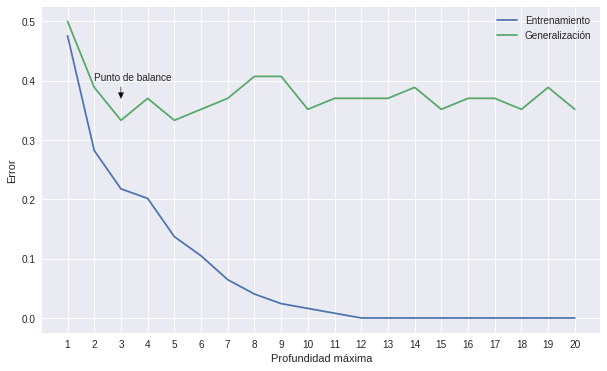

In [16]:
pl.figure(figsize = (10, 6))

pl.plot(max_depth_values, train_error, label="Entrenamiento")
pl.plot(max_depth_values, generalization_error, label="Generalización")
pl.xticks(max_depth_values)
pl.xlabel("Profundidad máxima")
pl.ylabel("Error")
pl.arrow(3, 0.39, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(2, 0.4, 'Punto de balance')
pl.legend();

##Visualización usando DecisionTree
###8. Escoja el mejor modelo entrenado sobre las 13 características. Visualice el árbol de decisión.

In [0]:


train_error = []
generalization_error = []
max_depth_values = list(range(1, 20, 1))



for depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train0, y_train0)
    train_error.append(1 - decision_tree.score(X_train0, y_train0))
    generalization_error.append(1 - decision_tree.score(X_test0, y_test0))
    
    
    


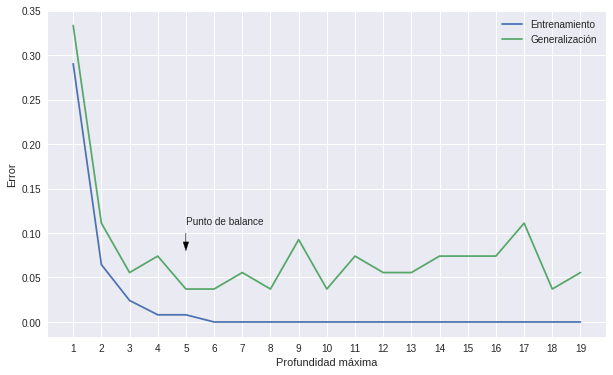

In [135]:
pl.figure(figsize = (10, 6))

pl.plot(max_depth_values, train_error, label="Entrenamiento")
pl.plot(max_depth_values, generalization_error, label="Generalización")
pl.xticks(max_depth_values)
pl.xlabel("Profundidad máxima")
pl.ylabel("Error")
pl.arrow(5, 0.10, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(5, 0.11, 'Punto de balance')
pl.legend();


In [142]:
decision_tree = DecisionTreeClassifier(max_depth=2)
decision_tree.fit(X_train1, y_train1)

decision_tree2 = DecisionTreeClassifier(max_depth=3)
decision_tree2.fit(X_train2, y_train2)


X = wine_df1.values
y= class_array.values

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)


decision_tree3 = DecisionTreeClassifier(max_depth=5)
decision_tree3.fit(X_train3, y_train3)



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

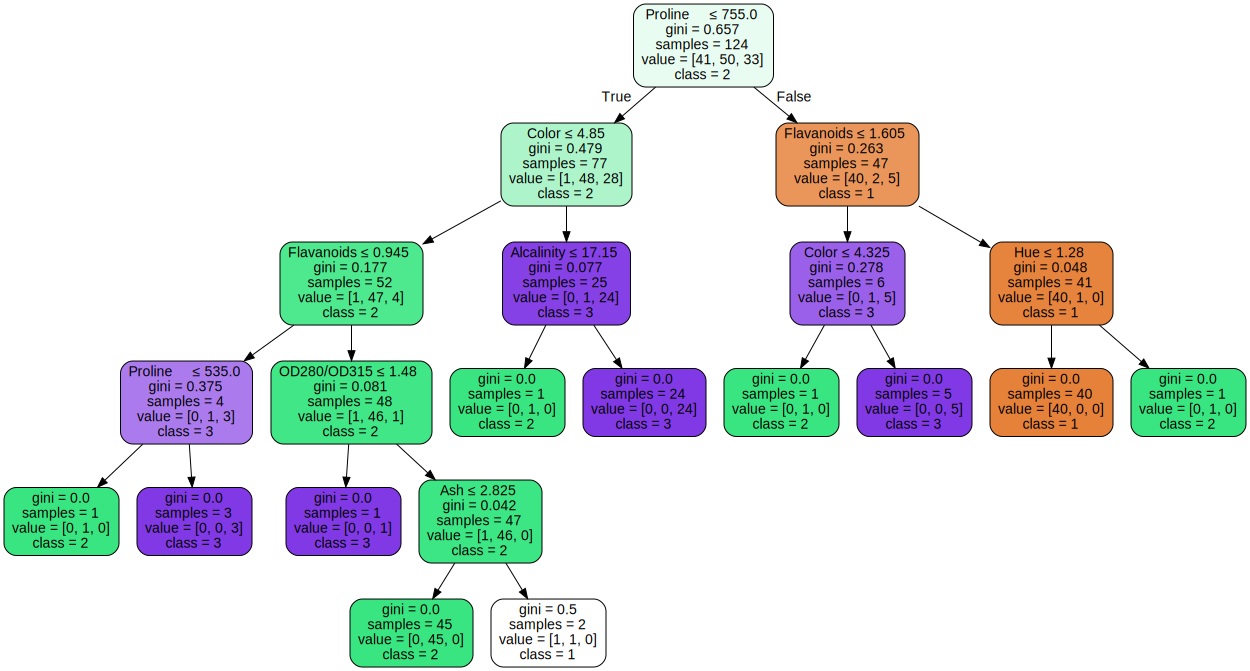

In [137]:
wine_df1= wine_df.drop(columns=["Class"])
from IPython.display import SVG
dot_data = export_graphviz(decision_tree3, out_file=None, 
                         feature_names=wine_df1.columns,  
                         class_names=["1","2","3"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
SVG(graph.pipe(format='svg'))


Text(0.5,1,'Arbol de decisión con proline y flavonoid')

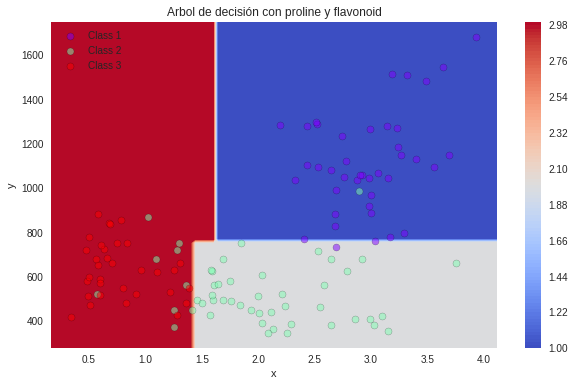

In [148]:

pl.figure(figsize = (10, 6)) 
plot_decision_region2(X_train1, gen_pred_fun(decision_tree))
plot_data(X_train1, y_train1)
pl.title("Arbol de decisión con proline y flavonoid")


###9. ¿Cuales son las características más importantes del modelo?

In [0]:
importances_array=decision_tree3.feature_importances_
columns_arr=wine_df1.columns

In [23]:
importances_dict={}
for i in range(13):
  index=columns_arr[i]
  value=importances_array[i]
  importances_dict[index]=value
  
importances_sorted_by_value = sorted(importances_dict.items(), key=lambda kv: kv[1],reverse=True)
print(importances_sorted_by_value)

[(' Proline    ', 0.42399287467938546), ('Color', 0.36042661224927236), (' OD280/OD315', 0.11458179774125589), (' Flavanoids', 0.050145257041808784), (' Alcalinity', 0.025631783411430187), (' Proanthocyanins', 0.025221674876847285), ('Alcohol', 0.0), (' Malic_acid', 0.0), (' Ash', 0.0), (' Magnesium', 0.0), (' Phenols', 0.0), (' Nonflavanoid', 0.0), (' Hue', 0.0)]


###10. Exprese 5 reglas de decisión con base en el árbol entrenado.

Para clasificar el tipo de vino, se pueden seguir las siguientes reglas:
1. si Proline <= 755.0 , Color <=4.85, Flavanoids <=0.945 entonces es de clase 3
2. si Proline <= 755.0 , Color >4.85, Alcalinity <= 17.15 entonces es de clase 2
3. si Proline > 755.0, OD280/OD315 <= 2.49 , Flavanoids <=0.9 entonces es de clase 3
4. si Proline > 755.0, OD280/OD315 > 2.49 , Alcalinity <= 27.5 entonces es de clase 1
5. si Proline > 755.0, OD280/OD315 > 2.49 , Alcalinity > 27.5 entonces es de clase 1